In [3]:
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

In [4]:
with open ("weatherAPI.txt", "r") as file:
    apiKey= file.read().strip()

city= input("Enter city name: ")

baseURL = "https://api.openweathermap.org/data/2.5/forecast"


url = f"{baseURL}?q={city}&appid={apiKey}"
response = requests.get(url)
data=response.json() #data is a dictionary given to us by the API
print(city, ": ")


Enter city name:  London


London : 


In [7]:
#Extract relevent data into an organised way in the weatherData variable
weatherData = [
    {
        'Date': item['dt_txt'],
        'Temperature': item['main']['temp'],
        'Humidity': item['main']['humidity'],
        'WindSpeed': item['wind']['speed']
    }
    for item in data['list']   #data['list'] is an unorganised list of dictionaries, we acess every dicitionary(named item in for loop) and we organise it
] #weather data is now a structured list of dictionaries.

In [9]:
df= pd.DataFrame(weatherData) #weather data now in tabulr form
df.shape

(40, 4)

In [11]:
# Create lagged features for Temperature, Humidity, and WindSpeed
df['Temperature_Lag1'] = df['Temperature'].shift(1)
df['Humidity_Lag1'] = df['Humidity'].shift(1)
df['WindSpeed_Lag1'] = df['WindSpeed'].shift(1)

In [13]:
df.head() #debug

,Date,Temperature,Humidity,WindSpeed,Temperature_Lag1,Humidity_Lag1,WindSpeed_Lag1
0,2025-01-15 21:00:00,281.71,92,1.25,NaN,NaN,NaN
1,2025-01-16 00:00:00,280.90,94,1.15,281.71,92.0,1.25
2,2025-01-16 03:00:00,279.68,95,1.35,280.90,94.0,1.15
3,2025-01-16 06:00:00,278.19,96,1.69,279.68,95.0,1.35
4,2025-01-16 09:00:00,278.24,96,1.23,278.19,96.0,1.69


In [15]:
# Drop rows with NaN values (first row will have NaN due to lagged features)
df = df.dropna() #rows with NaN are removed


In [17]:
df.head() #debug

,Date,Temperature,Humidity,WindSpeed,Temperature_Lag1,Humidity_Lag1,WindSpeed_Lag1
1,2025-01-16 00:00:00,280.90,94,1.15,281.71,92.0,1.25
2,2025-01-16 03:00:00,279.68,95,1.35,280.90,94.0,1.15
3,2025-01-16 06:00:00,278.19,96,1.69,279.68,95.0,1.35
4,2025-01-16 09:00:00,278.24,96,1.23,278.19,96.0,1.69
5,2025-01-16 12:00:00,281.38,79,2.28,278.24,96.0,1.23


In [19]:
#context for this cell: The resulting outcomes for tomorrow's weather highly depends on the weather of today, yesterday, day before yesterday etc
# hence we make the lag colums. temp_lag has the temperature for the day before while its respective temp has today's temperature
# as our model needs to study previous data, we will assign the lag columns to X, and the original(or next) columns to y



# Define X (features) and y (targets)
X = df[['Temperature_Lag1', 'Humidity_Lag1', 'WindSpeed_Lag1']] #lag columns assigned to X
y = df[['Temperature', 'Humidity', 'WindSpeed']] 

# Check the resulting DataFrame
print("Printing X")
print(X.head())
print("Printing y")
print(y.head())

Printing X
   Temperature_Lag1  Humidity_Lag1  WindSpeed_Lag1
1            281.71           92.0            1.25
2            280.90           94.0            1.15
3            279.68           95.0            1.35
4            278.19           96.0            1.69
5            278.24           96.0            1.23
Printing y
   Temperature  Humidity  WindSpeed
1       280.90        94       1.15
2       279.68        95       1.35
3       278.19        96       1.69
4       278.24        96       1.23
5       281.38        79       2.28


In [23]:
Xtrain, Xtest, yTrain, yTest = train_test_split(X, y, test_size=0.2)

In [25]:
model = LinearRegression()
model.fit(Xtrain, yTrain)
 

LinearRegression()

In [27]:
testPred = model.predict(Xtest)
score = mean_absolute_error(testPred, yTest)
print(score) #the difference between prediction and test. the lower the better

2.0317088040414535


In [29]:
yPredDf = pd.DataFrame(testPred, columns=['Temp Pred', 'Humidity Pred', 'Wind Speed Pred'])
yTestDf = yTest.reset_index(drop=True) # if yTest was originally a Series or indexed in a way that doesn’t align with the DataFrame, reset_index(drop=True) ensures that the indices align with those of the predictions (y_pred).
comparisonDf = pd.concat([yTestDf, yPredDf], axis=1) #concatenates the above two dataframes for easier comparision

print(comparisonDf)

   Temperature  Humidity  WindSpeed   Temp Pred  Humidity Pred  \
0       276.98        93       1.63  277.878423      89.029486   
1       278.02        87       1.38  279.764321      80.594279   
2       276.91        85       1.31  277.986415      86.148446   
3       275.79        88       1.25  277.027979      80.793072   
4       278.24        96       1.23  278.163549      92.548730   
5       277.10        89       1.75  279.124872      78.748807   
6       276.25        83       1.48  277.291515      83.067138   
7       275.95        91       1.79  277.361014      85.862757   

   Wind Speed Pred  
0         1.741195  
1         1.359542  
2         1.475720  
3         1.494387  
4         1.802537  
5         1.489528  
6         1.412674  
7         1.959474  


In [31]:
#making predictions for the next 5 days
futureInput = X.iloc[-1:]

futurePrediction = []

for _ in range(5):
    futureOutput = model.predict(futureInput)
    futurePrediction.append(futureOutput[0])

    futureInput =pd.DataFrame( 
        [[
        futureOutput[0][0],
        futureOutput[0][1],
        futureOutput[0][2]
        ]],
        columns = X.columns
    )

In [33]:
futurePredictionDF = pd.DataFrame(futurePrediction, columns = ['Temperature', 'Humidity', 'WindSpeed'])

In [35]:
print(futurePredictionDF)

   Temperature   Humidity  WindSpeed
0   278.717068  90.629688   1.618464
1   278.515680  89.754397   1.671966
2   278.440125  88.884761   1.693910
3   278.420750  88.198908   1.695132
4   278.419538  87.712750   1.685720


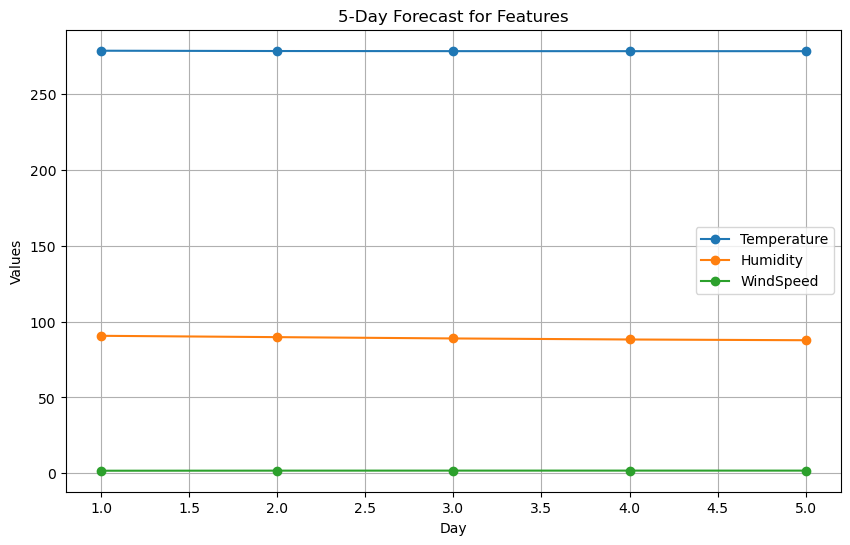

In [37]:
import matplotlib.pyplot as plt

# Add a column for days (1 to 5)
futurePredictionDF['Day'] = range(1, 6)

# Plot the features. makes a graph 10 inches widr and 6 inches tall
plt.figure(figsize=(10, 6))

plt.plot(futurePredictionDF['Day'], futurePredictionDF['Temperature'], label='Temperature', marker='o')
plt.plot(futurePredictionDF['Day'], futurePredictionDF['Humidity'], label='Humidity', marker='o')
plt.plot(futurePredictionDF['Day'], futurePredictionDF['WindSpeed'], label='WindSpeed', marker='o')

# Add titles and labels
plt.title('5-Day Forecast for Features')
plt.xlabel('Day')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# plt.ylim(276, 280) to adjust the scale of graph
# Display the plot
plt.show()
